In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2 as transforms

from aivolved.dataset import get_img_dataset_normalisation, CocoBinaryClassificationDataset, SiameseDataset

In [2]:
DATA_PATH = "data/soap_side/train/"

train_dataset = CocoBinaryClassificationDataset(DATA_PATH, {2, 3},
                                                transform=torchvision.transforms.Compose(
                                                    [torchvision.transforms.Resize((224, 224))]))
mean, stdev = get_img_dataset_normalisation(train_dataset)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [53]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((100, 100)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    torchvision.transforms.Normalize(mean, stdev)
])

train_dataset = CocoBinaryClassificationDataset(DATA_PATH, {2, 3}, transform=train_transforms)
valid_dataset = CocoBinaryClassificationDataset("data/soap_side/valid/", {2, 3}, transform=train_transforms)
test_dataset = CocoBinaryClassificationDataset("data/soap_side/test/", {2, 3}, transform=train_transforms)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
train_dataset.coco_dataset.coco.cats

{0: {'id': 0, 'name': 'SIDE1', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'bottom', 'supercategory': 'SIDE1'},
 2: {'id': 2, 'name': 'dent', 'supercategory': 'SIDE1'},
 3: {'id': 3, 'name': 'fuddher', 'supercategory': 'SIDE1'},
 4: {'id': 4, 'name': 'machine_part', 'supercategory': 'SIDE1'},
 5: {'id': 5, 'name': 'side', 'supercategory': 'SIDE1'}}

True

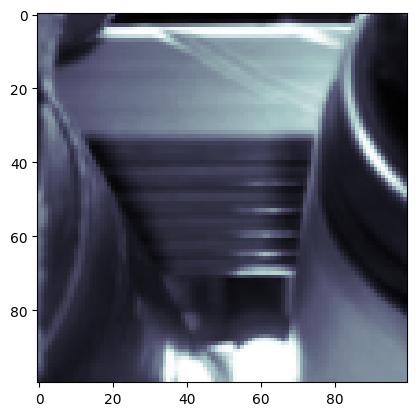

In [5]:
img, defective = train_dataset[20]

ax = plt.gca()
ax.imshow(img[2], cmap="bone")

defective

In [6]:
from torch.utils.data import DataLoader

triplet_dataset = SiameseDataset(train_dataset)

tensor(1.)

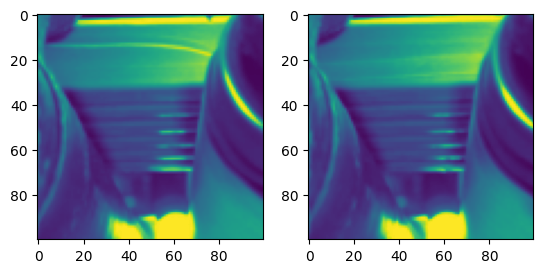

In [19]:
img1, img2, label = triplet_dataset[90]

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img1[2])
ax2.imshow(img2[2])
label

In [51]:
import lightning as pl


class ClassifierNetwork(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        self.criterion = torch.nn.MSELoss()

        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 1)
        torch.nn.init.xavier_uniform_(self.resnet.fc.weight)

    def forward(self, x):
        return self.resnet(x)

    def _step(self, batch, _, step: str):
        x, y = batch
        y_hat = self.forward(x).squeeze()

        loss = self.criterion(y_hat, y)
        acc = 100 * (torch.round(y_hat) == y).float().mean()
        self.log(f"{step}_loss", loss)
        self.log(f"{step}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        self._step(batch, batch_idx, "valid")

    def test_step(self, batch, batch_idx):
        self._step(batch, batch_idx, "test")

    def configure_optimizers(self):
        lr = 1e-5
        weight_decay = 5e-4
        
        params_1x = [param for name, param in self.resnet.named_parameters() if "fc" not in str(name)]
        optimizer = torch.optim.Adam([{"params": params_1x}, {"params": self.resnet.fc.parameters(), "lr": lr*10}], lr=lr, weight_decay=weight_decay)
        return optimizer
        

ClassifierNetwork()

ClassifierNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [37]:
from torchvision.models.resnet import ResNet18_Weights
import lightning as pl


class SiameseNetwork(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.resnet = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        fc_in_features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(fc_in_features * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.fc.apply(self.init_weights)
        
        self.criterion = nn.BCELoss()

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        output = torch.cat((output1, output2), 1)
        output = self.fc(output)
        return output

    def _step(self, batch, _, step: str):
        x1, x2, y = batch
        y_hat = self.forward(x1, x2).squeeze()
        
        loss = self.criterion(y_hat, y)
        acc = 100 * (torch.round(y_hat) == y).float().mean()
        self.log(f"{step}_loss", loss)
        self.log(f"{step}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        self._step(batch, batch_idx, "valid")

    def test_step(self, batch, batch_idx):
        self._step(batch, batch_idx, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam([{"params": self.resnet.parameters(), "lr": 1e-7},
                                      {'params': self.fc.parameters()}],
                                     lr=1e-6)
        return optimizer
    

SiameseNetwork()

SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [23]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: Currently logged in as: bhavye-mathur. Use `wandb login --relogin` to force relogin


True

In [24]:
wandb.finish()

model = SiameseNetwork()
wandb_logger = WandbLogger(project="soap-side-contrastive-learning")

In [25]:
train_dataloader = DataLoader(triplet_dataset, batch_size=256, num_workers=1, pin_memory=True, persistent_workers=True)

trainer = pl.Trainer(max_epochs=10, log_every_n_steps=3, logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=train_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/bhavyemathur/Desktop/Programming/Python/AIvolved/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.



  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | resnet    | Sequential | 11.2 M | train
1 | fc        | Sequential | 295 K  | train
2 | criterion | BCELoss    | 0      | train
-------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.888    Total estimated model params size (MB)
/Users/bhavyemathur/Desktop/Programming/Python/AIvolved/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [55]:
model = ClassifierNetwork()
wandb_logger = WandbLogger(project="soap-side-contrastive-learning")

train_dataloader = DataLoader(train_dataset, batch_size=256, num_workers=1, pin_memory=True, persistent_workers=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), num_workers=1, pin_memory=True, persistent_workers=True)

trainer = pl.Trainer(max_epochs=100, log_every_n_steps=3, logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
wandb.finish()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | resnet    | ResNet  | 11.2 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/bhavyemathur/Desktop/Programming/Python/AIvolved/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bhavyemathur/Desktop/Programming/Python/AIvolved/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▆▇█████████████████████████████████████
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_acc,▁▂▅▆█▇██████████████████████████████████
valid_loss,██▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_acc,100.0
train_loss,0.0
trainer/global_step,299
valid_acc,48.48485
